# Open-Source Frameworks for Deep Learning: an Overview


This notebook is part of the 2 hrs talk given at the Univerity of Bologna (DISI), Nuovo Campus Universitario, Via Pavese 50, Cesena, FC the 13th of December 2018, 10-12 am. Remember to include the copyright if you want to use, modify or distribute this notebook! :-) Slides of the talk are available [here](https://docs.google.com/presentation/d/1fbTKtp9xOlCL4JtpiLF39x7Vxq2Z-jgn77CTqcBrwEE/edit?usp=sharing).






---

**Abstract** : The rise of deep learning over the last decade has led to profound changes in the landscape of the machine learning software stack both for research and production. In this talk we will provide a comprehensive overview of the *open-source deep learning frameworks* landscape with both a theoretical and hands-on approach. After a brief introduction and historical contextualization, we will highlight common features and distinctions of their recent developments. Finally, we will take at deeper look into three of the most used deep learning frameworks today: *Caffe*, *Tensorflow*, *PyTorch*; with practical examples and considerations worth reckoning in the choice of such libraries.

**Short Bio** : [Vincenzo Lomonaco](https://vincenzolomonaco.com) is a Deep Learning PhD student at the University of Bologna and founder of [ContinualAI.org](https://continualai.org). He is also the PhD students representative at the Department of Computer Science of Engineering (DISI) and teaching assistant of the courses *“Machine Learning”* and *“Computer Architectures”* in the same department. Previously, he was a Machine Learning software engineer at IDL in-line Devices and a Master Student at the University of Bologna where he graduated cum laude in 2015 with the dissertation [“Deep Learning for Computer Vision: a Comparison Between CNNs and HTMs on Object Recognition Tasks"](https://amslaurea.unibo.it/9095/).

---

** Connecting a local runtime**

In case resources are not enough for you (no GPU for example), you can always connect another [local runtime](https://research.google.com/colaboratory/local-runtimes.html) or to a [runtime on a Google Compute Engine instance](https://research.google.com/colaboratory/local-runtimes.html). However, this notebook has been designed to run fast enough on simple CPUs so you shouldn't fined any trouble here, using a free *hosted account*.


**Requisites to run it locally, outside colab (not recommended)**

*   Python 3.x
*   Jupyter
*   Numpy
*   Matplolib
*   Pytorch 0.4.0
*   Caffe 1.0.0
*  Tensorflow 1.12

# Hands-on session (45 minutes)

In this session we will try to learn an evaluate a Convolutional Neural Networks model on [MNIST](http://yann.lecun.com/exdb/mnist/) using three of the most used deep learning frameworks today: *Caffe*, *Tensorflow*, *PyTorch* with an expected timeframe of 15 minutes for each of them. This will allow us to grasp what it means to train a deep model with such libraries and compare the different Python APIs for this simple use case.

## Google Colaboratory

First of all, take a moment to look around and discover Google Colab if you haven't before! You can run the commands below to understand how much resources you're using and are still available. Then consider also that you can also connect you Google Drive for additional space or for easily loading your own files. Check out the [official tutorial](https://colab.research.google.com/) of the Google Colaboratory for more information.

You can always reset the entire VM with "*Runtime > Reset all runtime*" in case of difficulty. Make also sure you're using the GPU or TPU in the same tab ("*Runtime > Change runtime type*").

In [28]:
!free -m
!df -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:          13022        2998        1992          67        8031       10763
Swap:             0           0           0
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   18G  323G   6% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/sda1       365G   22G  344G   6% /opt/bin
tmpfs           6.4G  8.0K  6.4G   1% /var/colab
shm             6.0G  4.0K  6.0G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
Sat Dec 15 13:57:37 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Uti

Questions to explore:

*   How to connect your Google Drive with Google Colab?
*   How to import a new notebook and save it to your GDrive?
*  How to use files which are contained in your GDrive?

Some tips here: https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d


## Loading the MNIST Benchamark

in this section we load the common MNIST benchmark which we will use for our examples. We will take advantage of the *ContinualAI* calab scripts for easy loading of the MNIST images as numpy tensors:

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

fatal: destination path 'continualai/colab' already exists and is not an empty directory.


In [31]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


In [32]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


Let us take a look at these images:

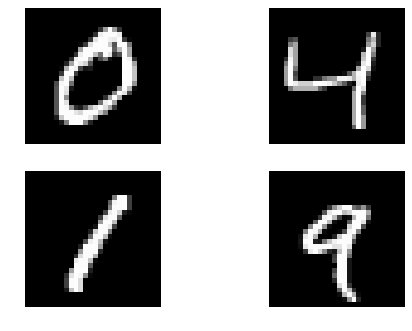

In [33]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

## Common Constants

Now we can move on and define some common constants that we will share across the DL framework experiments:

In [34]:
# we will use time to measure speed
import time

# number of classes in the MNIST dataset
num_class = 10

# number of epochs we will use for each training
n_epochs = 2

# mini-batch size for SGD
minibatch_size = 100

# Iterations for epoch for the two sets
tr_it_for_epoch = t_train.shape[0] // minibatch_size
te_it_for_epoch = t_test.shape[0] // minibatch_size
print("train iterations: ", tr_it_for_epoch)
print("test iterations: ", te_it_for_epoch)

train iterations:  600
test iterations:  100


## Training a ConvNet with Caffe

Let us focus on *Caffe*. First of all let us install the library. Luckily enough for Ubuntu (>= 17.04) there is a packaged version we can install simply with:

In [35]:
# !apt install -y caffe-cpu
!apt install -y caffe-cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
caffe-cuda is already the newest version (1.0.0-6build1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


Let us now import the library and check the version:

In [36]:
import caffe
caffe.__version__


'1.0.0'

Now we can set the hardware type:

In [0]:
#caffe.set_mode_cpu()
caffe.set_device(0)
caffe.set_mode_gpu()

Great! Now that we have caffe imported and configured, we can focus on the definition of our ConvNet and the training/testing procedures. The easiest way to define the network structure and the opimization parameters is to define two separate prototxts files. In this case we I have already prepared the net.prototxt and solver.prototxt files which we can import front the *ContinualAI-colab* toolchain:

In [0]:
!cp continualai/colab/extras/net.prototxt .
!cp continualai/colab/extras/solver.prototxt .
solver_name = "solver.prototxt"

Before moving on let's visualize them with the awesome netscope tool: 

*   [net.prototxt](http://ethereon.github.io/netscope/#/gist/fbc84e148391c5bd953a5ec7d613b0f9)
*   [solver.prototxt](https://gist.github.com/vlomonaco/82dbff5eab77e146b489d27a5cd5923f)

Now we can define our test method:

In [0]:
def test(net, x, y, test_iters, test_batch_size):
    """ test the trained net """

    acc = 0
    loss = 0
    for it in range(test_iters):
        if it % 100 == 1: print("+", end="", flush = True)
        start = it * test_batch_size
        end = (it + 1) * test_batch_size
        net.blobs['data'].data[...] = x[start:end]
        net.blobs['label'].data[...] = y[start:end]
        
        blobs = net.forward(["accuracy", "loss"])
        acc += blobs["accuracy"]
        loss += blobs["loss"]

    return acc / test_iters, loss / test_iters

Load the solver and start the training procedure:

In [40]:
solver = caffe.get_solver(solver_name)

t_start = time.time()
print("Start Training")

for epoch in range(n_epochs):
  print("Epoch", epoch, " ", end="")
  for it in range(tr_it_for_epoch):

    if it % 100 == 1: print(".", end="", flush=True)   
    start = it * minibatch_size
    end = (it + 1) * minibatch_size
    solver.net.blobs['data'].data[...] = x_train[start:end]
    solver.net.blobs['label'].data[...] = t_train[start:end]
    solver.step(1)

  train_acc, train_loss = test(solver.test_nets[0], x_train, t_train,
                     tr_it_for_epoch, minibatch_size)
  test_acc, _ = test(solver.test_nets[0], x_test, t_test,
                     te_it_for_epoch, minibatch_size)
  print("  Train loss: %.4f  Train acc: %.2f %%  Test acc: %.2f %%" %
        (train_loss, train_acc * 100, test_acc * 100))

t_elapsed = time.time()-t_start
print("---------------------------------------------")
print ('%d patterns (%.2f sec.) -> %.2f patt/sec' % 
       (x_train.shape[0]*n_epochs, t_elapsed, 
        x_train.shape[0]*n_epochs / t_elapsed))
print("---------------------------------------------")

Start Training
Epoch 0  ......+++++++  Train loss: 0.0988  Train acc: 96.82 %  Test acc: 96.65 %
Epoch 1  ......+++++++  Train loss: 0.0451  Train acc: 98.54 %  Test acc: 98.13 %
---------------------------------------------
120000 patterns (112.29 sec.) -> 1068.70 patt/sec
---------------------------------------------


### [Extra] Define model and solver from Python

Of course is it possible to define the network directly in Python as shown below. However we leave this part as optional for the reader to explore.

In [0]:
from caffe import layers as L
from caffe import params as P
from caffe.proto import caffe_pb2
from google.protobuf import text_format

def get_net(num_classes=10, train_mb_size=100):
    """ Define net and return it as String """

    net = caffe.NetSpec()

    net.data = L.Input(
        shape=[dict(dim=[train_mb_size, 1, 28, 28, ])], ntop=1,
        include=dict(phase=caffe.TRAIN)
    )
    net.test_data = L.Input(
        shape=[dict(dim=[100, 1, 28, 28, ])], ntop=1,
        include=dict(phase=caffe.TEST)
    )
    net.label = L.Input(
        shape=[dict(dim=[train_mb_size])], ntop=1,
        include=dict(phase=caffe.TRAIN)
    )
    net.test_label = L.Input(
        shape=[dict(dim=[100])], ntop=1,
        include=dict(phase=caffe.TEST)
    )
    net.conv1 = L.Convolution(
        net.data, kernel_size=5,
        num_output=32, param=[dict(lr_mult=1), dict(lr_mult=2)],
        weight_filler=dict(type='xavier'),
        bias_filler=dict(type='constant')
    )
    net.relu1 = L.ReLU(net.conv1, in_place=True)

    net.conv2 = L.Convolution(
        net.relu1, kernel_size=5,
        num_output=32, param=[dict(lr_mult=1), dict(lr_mult=2)],
        weight_filler=dict(type='xavier'),
        bias_filler=dict(type='constant')
    )
    net.relu2 = L.ReLU(net.conv2, in_place=True)

    net.fc1 = L.InnerProduct(
        net.relu2, num_output=500,
        param=[dict(lr_mult=1), dict(lr_mult=2)],
        weight_filler=dict(type='xavier'),
        bias_filler=dict(type='constant')
    )
    net.relu3 = L.ReLU(net.fc1, in_place=True)

    net.out = L.InnerProduct(
        net.fc1, num_output=num_classes,
        param=[dict(lr_mult=1), dict(lr_mult=2)],
        weight_filler=dict(type='xavier'),
        bias_filler=dict(type='constant')
    )

    net.loss = L.SoftmaxWithLoss(net.out, net.label)
    
    net.accuracy = L.Accuracy(
        net.out, net.test_label, include=dict(phase=caffe.TEST)
    )

    proto = str(net.to_proto())
    proto = proto.replace('test_data', 'data').replace('test_label', 'label')\
        .replace('test_target', 'target')
    
    return proto

def get_solver( net, base_lr, random_seed=1, lr_policy="step", gamma=0.1,
    stepsize=100000000, momentum=0.9, weight_decay=0.0005, test_iter=0,
    test_interval=1000, display=20, solver_mode=caffe_pb2.SolverParameter.GPU):
    """ Define solver and return it as String """

    solver_config = caffe_pb2.SolverParameter()

    solver_config.random_seed = random_seed
    solver_config.test_iter.append(1)
    solver_config.test_interval = 1
    solver_config.net = net
    solver_config.base_lr = base_lr
    solver_config.lr_policy = lr_policy
    solver_config.gamma = gamma
    solver_config.stepsize = stepsize
    solver_config.momentum = momentum
    solver_config.weight_decay = weight_decay
    solver_config.snapshot_format = caffe_pb2.SolverParameter.HDF5
    solver_config.solver_mode = solver_mode

    solver_config = text_format.MessageToString(
        solver_config, float_format='.6g'
    )

    return solver_config

In [0]:
net_name = "net.prototxt"

with open(net_name, "w") as wf:
  wf.write(get_net())
  
with open(solver_name, "w") as wf:
  wf.write(get_solver(net_name, base_lr=0.01))

Questions to explore:

*   How to recover the weights of a particular layer?
*   How to get the activations of a particular layer?
*  How to cast a classifier into a Fully Convolutional Network?

Some tips here: https://github.com/BVLC/caffe/blob/master/examples/net_surgery.ipynb


## Training a ConvNet with Tensorflow

Let us move to the second framework we are considering: *Tensorflow*. We don't need to install it since it's already pre-loaded in Google Colaboratory (guess why! :'D). So let us start by importing it and checking the version:

In [43]:
import tensorflow as tf
print(tf.__version__)
tf.reset_default_graph()

1.12.0


Then we can define directly the network structure using the tf.layers API:

In [0]:
x = tf.placeholder(tf.float32, shape=[minibatch_size, 1, 28, 28])
t = tf.to_int64(tf.placeholder(tf.int32, shape=[minibatch_size]))

# First Convolutional Layer
x_image = tf.reshape(x, [-1,28,28,1])
conv1 = tf.layers.conv2d(
    x_image, 32, 5, strides=(1, 1), padding='valid', activation=tf.nn.relu
)

# Second Convolutional Layer
conv2 = tf.layers.conv2d(
    conv1, 32, 5, strides=(1, 1), padding='valid', activation=tf.nn.relu
)
pool2 = tf.layers.flatten(conv2)

# Densely Connected Layer
fc1 = tf.layers.dense(pool2, 500, name="fc1", activation=tf.nn.relu)

# Output Layer
y_logits = tf.layers.dense(fc1, num_class, name="logits")

# Train and Evaluate the Model
cross_entropy = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_logits, labels=t)
)
optim = tf.train.MomentumOptimizer(1e-2, momentum=0.9)
train_step = optim.minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_logits,1), t)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
loss = tf.reduce_mean(cross_entropy)

As for caffe we can define the *test* function:

In [0]:
def test(x_set, y_set, test_iters, test_batch_size):
    """ testing set accuracy: can be used for train and test"""
    
    accuracy_sum = 0.0
    for it in range(test_iters):
        if it % 100 == 1: print("+", end="", flush = True)
        start = it * test_batch_size
        end = (it + 1) * test_batch_size
        accuracy_sum += sess.run(
            fetches=accuracy,
            feed_dict={x: x_set[start:end], t: y_set[start:end]}
        )
      
    return accuracy_sum / test_iters

And then we can use the computational graph just created within an interactive session:

In [46]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

t_start = time.time()
print("Start Training")
train_loss = 0
for epoch in range(n_epochs):
    print("Epoch", epoch, " ", end="")
    for it in range(tr_it_for_epoch):
        if it % 100 == 1: print(".", end="", flush = True)
        start = it * minibatch_size
        end = (it + 1) * minibatch_size
        batch_loss, _ = sess.run(
            fetches=[loss, train_step],
            feed_dict={x: x_train[start:end], t: t_train[start:end]}
        )
        train_loss += batch_loss

    train_loss = train_loss / tr_it_for_epoch
    train_acc = test(
        x_train, t_train, tr_it_for_epoch, minibatch_size,
    )  
    test_acc = test(
        x_test, t_test, te_it_for_epoch, minibatch_size,
    )

    print("  Train loss: %.4f  Train acc: %.2f %%  Test acc: %.2f %%" %
        (train_loss, train_acc * 100, test_acc * 100))
    
t_elapsed = time.time()-t_start
print("---------------------------------------------")
print ('%d patterns (%.2f sec.) -> %.2f patt/sec' % 
       (x_train.shape[0]*n_epochs, t_elapsed, 
        x_train.shape[0]*n_epochs / t_elapsed))
print("---------------------------------------------")

sess.close()

Start Training
Epoch 0  ......+++++++  Train loss: 0.2559  Train acc: 97.60 %  Test acc: 97.40 %
Epoch 1  ......+++++++  Train loss: 0.0604  Train acc: 98.26 %  Test acc: 97.80 %
---------------------------------------------
120000 patterns (20.27 sec.) -> 5920.06 patt/sec
---------------------------------------------


### [Extra] Keras API

As an bonus we leave to the reader the same implementation but using the keras API. Very easy, isn't it? But remember, with great abstraction power comes great responsibility...

In [47]:
tf.keras.backend.set_image_data_format('channels_first')

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(
      32, (5, 5), strides=(1, 1), padding='valid', activation=tf.nn.relu
  ),
  tf.keras.layers.Conv2D(
      32, (5, 5), strides=(1, 1), padding='valid', activation=tf.nn.relu
  ),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(500, activation=tf.nn.relu),
  tf.keras.layers.Dense(num_class, activation=tf.nn.softmax)
])
optim = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

t_start = time.time()
print("Start Training")

model.fit(x_train, t_train, batch_size=minibatch_size, epochs=n_epochs)
model.evaluate(x_test, t_test)

t_elapsed = time.time()-t_start
print("---------------------------------------------")
print ('%d patterns (%.2f sec.) -> %.2f patt/sec' % 
       (x_train.shape[0]*n_epochs, t_elapsed, 
        x_train.shape[0]*n_epochs / t_elapsed))
print("---------------------------------------------")

Start Training
Epoch 1/2
60000/60000 [==============================] - 8s 131us/step - loss: 0.0366 - acc: 0.9888
Epoch 2/2
10000/10000 [==============================] - 1s 98us/step
---------------------------------------------
120000 patterns (17.05 sec.) -> 7040.14 patt/sec
---------------------------------------------


Questions to explore:

*   What happens if you comment the first line of code?
*   What if you also change the convolution padding from "valid" to "same"?

Some tips here: https://keras.io/layers/convolutional/


## Training a ConvNet with PyTorch

Let us delve now into the third and last framework we will consider: Pytorch. First of all let us install it and import it.

In [48]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' #'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Platform:', platform, 'Accelerator:', accelerator)

!pip install --upgrade --force-reinstall -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

Platform: cp36-cp36m Accelerator: cu80
tcmalloc: large alloc 1073750016 bytes == 0x5b6a8000 @  0x7f19cfe102a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.
google-colab 0.0.1a1 has requirement six~=1.11.0, but you'll have six 1.12.0 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
Torch 0.4.0 CUDA 8.0.61


In [49]:
import torch
torch.cuda.is_available()

True

In [0]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

In [0]:
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

**Questions to explore:**

*   What's new in Pythorch 0.4?

Some tips here: https://pytorch.org/blog/pytorch-0_4_0-migration-guide/


Great! So now we can define the network and the independent forward function which can dynamically change depending on the input data:

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.fc1 = nn.Linear(512, 500)
        self.fc2 = nn.Linear(500, num_class)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

We can define the test method as before:

In [0]:
def test(model, device, x_test, t_test, test_iters, test_batch_size):
    model.eval()
    test_loss = 0
    correct = 0
    for it in range(test_iters):
        if it % 100 == 1: print("+", end="", flush = True)
        start = it * test_batch_size
        end = (it + 1) * test_batch_size
        with torch.no_grad():
            x = torch.from_numpy(x_test[start:end])
            y = torch.from_numpy(t_test[start:end]).long()
            x, y = x.to(device), y.to(device)
            output = model(x)
            # sum up batch loss
            test_loss += F.cross_entropy(output, y).item() 
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(y.view_as(pred)).sum().item()

    return correct / len(t_test)

Then finally define the model and start the training:

In [54]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.train()

t_start = time.time()
print("Start Training")
train_loss = 0

for epoch in range(n_epochs):
    print("Epoch", epoch, " ", end="")
    train_loss = 0
    for it in range(tr_it_for_epoch):
        if it % 100 == 1: print(".", end="", flush = True)
        start = it * minibatch_size
        end = (it + 1) * minibatch_size
        x = torch.from_numpy(x_train[start:end])
        y = torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)
      
        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss
    
    train_loss = train_loss / tr_it_for_epoch
    train_acc = test(
        model, device, x_train, t_train, tr_it_for_epoch, minibatch_size,
    )  
    test_acc = test(
        model, device, x_test, t_test, te_it_for_epoch, minibatch_size,
    )

    print("  Train loss: %.4f  Train acc: %.2f %%  Test acc: %.2f %%" %
        (train_loss, train_acc * 100, test_acc * 100))
    
t_elapsed = time.time()-t_start
print("---------------------------------------------")
print ('%d patterns (%.2f sec.) -> %.2f patt/sec' % 
       (x_train.shape[0]*n_epochs, t_elapsed, 
        x_train.shape[0]*n_epochs / t_elapsed))
print("---------------------------------------------")

Start Training
Epoch 0  ......+++++++  Train loss: 0.3784  Train acc: 97.12 %  Test acc: 97.43 %
Epoch 1  ......+++++++  Train loss: 0.0778  Train acc: 98.06 %  Test acc: 98.05 %
---------------------------------------------
120000 patterns (8.33 sec.) -> 14403.05 patt/sec
---------------------------------------------


Wow! ~98% accuracy in such a short time.

**Questions to explore:**

*   Can you find a better parametrization to improve the final accuracy?
*   Can you change the network architecture to improve the final accuracy?
*   Can you achieve the same performances with a smaller architecture?
*   What's the difference in accuracy if you change convolutions with fully connected layers?
* Can you improve the speed of the training for all the frameworks described above?
* What are the pros and cons of each framework in this simple example?

Some tips here: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

This concludes our little tour of the thre most used open-source frameworks for Deep Learning. Please make a PR if you spot any error or you want to contribute to the **ContinualAI-Colab** project! :-) 

**Copyright (c) 2018. Continual AI. All rights reserved. **

See the accompanying LICENSE file in the GitHub repository for terms. 

*Date: 27-11-2018                                                             
Author: Vincenzo Lomonaco                                                    
E-mail: contact@continualai.org                                           
Website: continualai.org*              